In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from google.colab import files
files.upload()

Saving gan.py to gan.py


{'gan.py': b'import numpy as np\nimport torch\nfrom torch import nn, optim\nfrom facenet_pytorch import InceptionResnetV1\nimport pdb\nimport utils\nimport time\nimport matplotlib.pyplot as plt\n\n\nclass Generator(nn.Module):\n    def __init__(self, learning_rate=1e-3, weight_decay=1e-3, load_path=None):\n        """Initialize generator for sampling facemask designs from latent space"""\n        super(Generator, self).__init__()\n        self.input_dim = 100\n        self.output_dim = (3, 128, 128)\n        self.learning_rate = learning_rate\n\n        # network layers\n        # input: 100-dim latent vector\n        # output: 64x64x3 RGB image\n        self.h1 = nn.Sequential(\n            nn.Linear(self.input_dim, 32),\n            nn.ReLU(),\n        )\n        self.h2 = nn.Sequential(\n            nn.Linear(32, 32),\n            nn.ReLU(),\n        )\n        self.output = nn.Sequential(\n            nn.Linear(32, np.prod(self.output_dim)),\n            nn.Sigmoid(),\n        )\n\

In [ ]:
!pip3 install facenet-pytorch

     |████████████████████████████████| 1.9 MB 5.1 MB/s 


In [ ]:
# imports
import numpy as np
from facenet_pytorch import MTCNN, InceptionResnetV1
import pdb
import torch
from torchvision.transforms import ToTensor, Resize
from PIL import Image
import matplotlib.pyplot as plt

# autoreload
%load_ext autoreload
%autoreload 2

### Load data and display a sample of masked and unmasked faces

<Figure size 432x288 with 0 Axes>

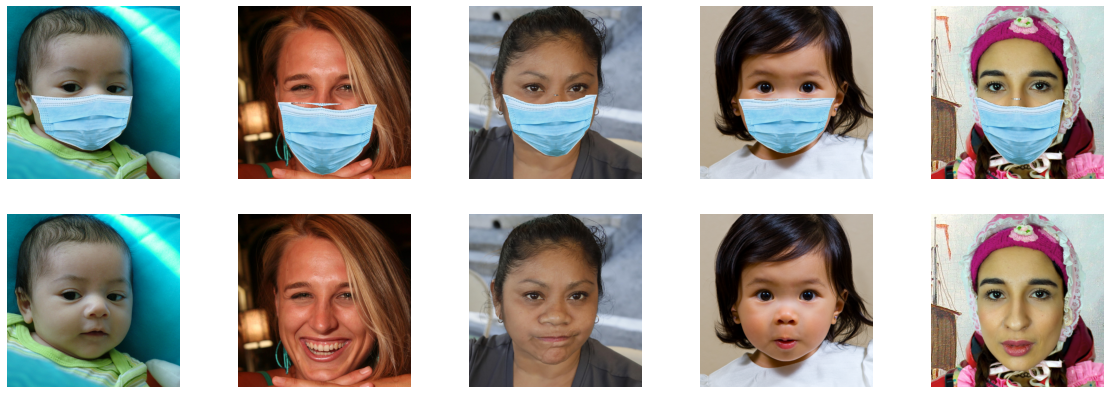

In [ ]:
# parameters
num_faces = 20  # total number of faces to load
offset = 0  # offset of file indices

# load masked and unmasked faces
img_size = 128
masked_faces = torch.zeros((num_faces, 3, 128, 128))
unmasked_faces = torch.zeros((num_faces, 3, 128, 128))
plt.figure()
fig, axes = plt.subplots(2, 5)
fig.set_figwidth(20)
fig.set_figheight(7)
face_id = 0
skipped = 0
idx_to_face_id = []
while face_id < num_faces:
    # get image paths
    face_id_text = str(100000 + face_id + skipped + offset)[1:]
    masked_path = '/content/drive/MyDrive/ai-facemask-gans/dataset/masked/images/{}_Mask.jpg'.format(face_id_text)
    unmasked_path = '/content/drive/MyDrive/ai-facemask-gans/dataset/unmasked/images/{}.png'.format(face_id_text)
    
    # load images
    try:
        masked_img = Image.open(masked_path)
        unmasked_img = Image.open(unmasked_path)
    except:  # skip missing images
        skipped += 1
        continue
        
    # process images
    masked_tensor = Resize((img_size,img_size))(ToTensor()(masked_img)) - .5
    unmasked_tensor = Resize((img_size,img_size))(ToTensor()(unmasked_img)) - .5
    if masked_tensor is None or unmasked_tensor is None:
        skipped += 1
        continue
        
    # display images
    if face_id < 5:
        axes[0,face_id].imshow(masked_img)
        axes[0,face_id].set_axis_off()
        axes[1,face_id].imshow(unmasked_img)
        axes[1,face_id].set_axis_off()
    
    # save images to respective tensors
    masked_faces[face_id] = masked_tensor
    unmasked_faces[face_id] = unmasked_tensor
    idx_to_face_id.append(int(face_id + skipped))
    face_id += 1

In [ ]:
!python '/content/drive/MyDrive/ai-facemask-gans/gan.py'

### Setup the neural networks

In [ ]:
# instantiate GAN
from gan import Generator, Projector, Discriminator, GAN
generator = Generator(learning_rate=2e-3, load_path='/content/drive/MyDrive/ai-facemask-gans/models/generator.pt')
projector = Projector(load_path='/content/drive/MyDrive/ai-facemask-gans/models/projector.pt')
discriminator = Discriminator()
gan = GAN(generator, projector, discriminator)

# compute and store unmasked discriminator embeddings
gan.compute_unmasked_embeddings(unmasked_faces)

  0%|          | 0.00/107M [00:00<?, ?B/s]

### Train the models

In [ ]:
# split data into training and testing sets
split = int(.8 * num_faces)
static_faces = unmasked_faces[:split]
train_input, train_output = masked_faces[:split], torch.Tensor(idx_to_face_id[:split]).long()
test_input, test_output = masked_faces[split:], torch.Tensor(idx_to_face_id[split:]).long()

# train
gan.fit(train_input, static_faces, train_output, num_epochs=100)
gan.learning_rate = 2e-4
gan.fit(train_input, static_faces, train_output, num_epochs=100)

Epoch 10 loss: 0.21360766887664795
Epoch 20 loss: 0.21125583350658417
Epoch 30 loss: 0.20533813536167145
Epoch 40 loss: 0.19985270500183105
Epoch 50 loss: 0.19679546356201172
Epoch 60 loss: 0.19463108479976654
Epoch 70 loss: 0.19328024983406067
Epoch 80 loss: 0.19233877956867218
Epoch 90 loss: 0.19155935943126678
Epoch 100 loss: 0.1908428966999054
Epoch 10 loss: 0.19007918238639832
Epoch 20 loss: 0.18959234654903412
Epoch 30 loss: 0.1892007738351822
Epoch 40 loss: 0.1888274997472763
Epoch 50 loss: 0.18850263953208923
Epoch 60 loss: 0.18834206461906433
Epoch 70 loss: 0.18813230097293854
Epoch 80 loss: 0.18807749450206757
Epoch 90 loss: 0.18797089159488678
Epoch 100 loss: 0.18790236115455627


0.18790236115455627

### Display a sample of generated facemasks

<Figure size 432x288 with 0 Axes>

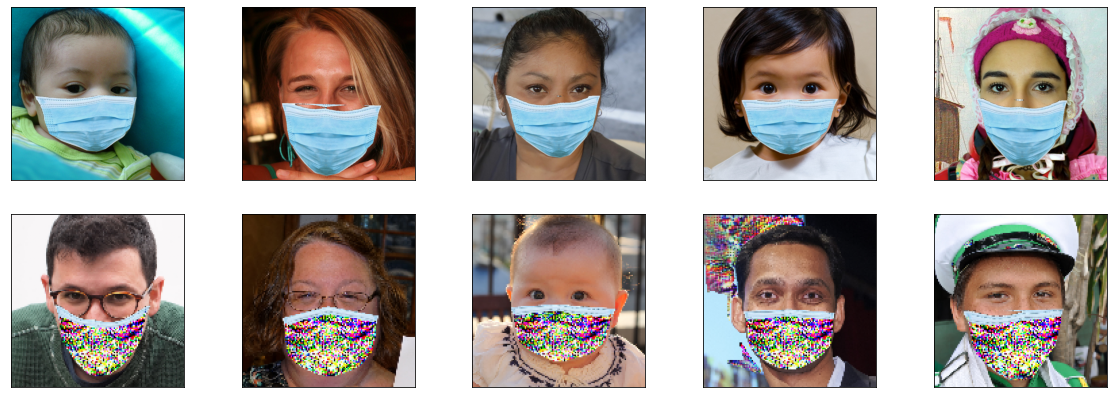

In [ ]:
plt.figure()
fig, axes = plt.subplots(2, 5)
fig.set_figwidth(20)
fig.set_figheight(7)
for idx in range(5):
    # original image
    face_id = idx_to_face_id[idx]
    face_id_text = str(100000 + face_id)[1:]
    original_img = Image.open('/content/drive/MyDrive/ai-facemask-gans/dataset/masked/images/{}_Mask.jpg'.format(face_id_text))
    axes[0,idx].imshow(original_img)
    axes[0,idx].get_xaxis().set_ticks([])
    axes[0,idx].get_yaxis().set_ticks([])
    
    # generated mask image
    mask = gan.generator()
    masked_tensor = masked_faces[idx].unsqueeze(0)
    masked_image = gan.project_mask(mask, masked_tensor, process=True)[0]
    masked_image = torch.transpose(masked_image, 0, 1)
    masked_image = torch.transpose(masked_image, 1, 2)
    masked_image = masked_image.detach().numpy()
    axes[1,idx].imshow(masked_image)
    axes[1,idx].get_xaxis().set_ticks([])
    axes[1,idx].get_yaxis().set_ticks([])

### Evaluate discriminator's facial recognition accuracy

* random choice - chance of guessing the person's identity correctly
* training images - recognition accuracy on training data
* testing images - recognition accuracy on testing data
* original masked images - recognition accuracy on images of individuals with blue, disposable facemasks
* original unmasked images - recognition accuracy on images of unmasked individuals

In [ ]:
# evaluate accuracy
train_accuracy = gan.evaluate(train_input, train_output)
test_accuracy = gan.evaluate(test_input, test_output)
masked_accuracy = gan.discriminator.evaluate(masked_faces, unmasked_faces)
unmasked_accuracy = gan.discriminator.evaluate(unmasked_faces, unmasked_faces)
print('facial recognition accuracy for...')
print('   random choice:\t\t{:.1f}%'.format(100 / num_faces))
print('   training images:\t\t{:.1f}%'.format(100 * train_accuracy))
print('   testing images:\t\t{:.1f}%'.format(100 * test_accuracy))
print('   original masked images:\t{:.1f}%'.format(100 * masked_accuracy))
print('   original unmasked images:\t{:.1f}%'.format(100 * unmasked_accuracy))

facial recognition accuracy for...
   random choice:		5.0%
   training images:		25.0%
   testing images:		100.0%
   original masked images:	75.0%
   original unmasked images:	100.0%
